In [1]:
import uproot
import random
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # barra di avanzamento grafica
from scipy.optimize import curve_fit

### Funzioni utili nel corso del programma

In [2]:
def plot_min_histogram(pshapes, bins, title_suffix=""):
    cleaned = pshapes[:, :2500]
    cleaned = np.where(np.abs(cleaned) > 1e5, np.nan, cleaned)
    min_values = -np.nanmin(cleaned, axis=1)

    print(f"Numero totale di vettori analizzati: {len(min_values)}")
    print("Esempio primi minimi:", min_values[:10])

    plt.figure(figsize=(8,4))
    plt.hist(min_values, bins=bins, color='lightgreen', edgecolor='black')
    plt.xlabel("Ampiezza minima")
    plt.ylabel("Occorrenze")
    plt.title(f"Istogramma dei minimi dei vettori pshape {title_suffix}")
    plt.tight_layout()
    plt.show()
    
    return min_values

def rc_lowpass(pshapes, sampling_time_s, fc):
    """
    Applica un filtro RC passa basso digitale a ciascun vettore pshape.
    Mostra una barra di avanzamento grafica con tqdm.
    """
    alpha = 2 * np.pi * fc * sampling_time_s / (1 + 2 * np.pi * fc * sampling_time_s)
    filtered = np.empty_like(pshapes)

    for i, vec in enumerate(tqdm(pshapes, desc="Filtraggio RC")):
        y = np.zeros_like(vec)
        y[0] = vec[0]
        for n in range(1, len(vec)):
            y[n] = y[n-1] + alpha * (vec[n] - y[n-1])
        filtered[i] = y

    return filtered

import numpy as np
from scipy.signal import bessel, lfilter
from tqdm import tqdm

def bessel_lowpass(pshapes, sampling_time_s, fc, order=4):
    """
    Applica un filtro Bessel passa basso digitale a ciascun vettore pshape.
    Mostra una barra di avanzamento grafica con tqdm.
    
    order: ordine del filtro Bessel
    """
    fs = 1 / sampling_time_s  # frequenza di campionamento
    nyquist = fs / 2
    Wn = fc / nyquist  # frequenza normalizzata
    b, a = bessel(order, Wn, btype='low', analog=False, norm='phase')
    
    filtered = np.empty_like(pshapes)
    
    for i, vec in enumerate(tqdm(pshapes, desc="Filtraggio Bessel")):
        filtered[i] = lfilter(b, a, vec)
    
    return filtered


def plot_random_waveform(pshapes_original, pshapes_filtered):
    n_events = pshapes_original.shape[0]
    idx = np.random.randint(0, n_events)
    vec_orig = pshapes_original[idx]
    vec_filt = pshapes_filtered[idx]

    plt.figure(figsize=(10,4))
    plt.plot(vec_orig, label="Originale")
    plt.plot(vec_filt, label="Filtrato RC 10 kHz")
    plt.xlabel("Campione")
    plt.ylabel("Ampiezza [V]")
    plt.title(f"Vettore casuale evento {idx} pre e post filtro")
    plt.legend()
    plt.tight_layout()
    plt.show()

def asymmetric_gaussian(x, A, mu, sigma_left, sigma_right):
    """Gaussiana con sigma diversa a sinistra e a destra del centro."""
    y = np.zeros_like(x)
    left_mask = x < mu
    right_mask = x >= mu
    y[left_mask] = A * np.exp(-0.5 * ((x[left_mask] - mu)/sigma_left)**2)
    y[right_mask] = A * np.exp(-0.5 * ((x[right_mask] - mu)/sigma_right)**2)
    return y

### Filtraggio pshapes @ 100 kHz - CD188

In [8]:
# Funzioni di prima (rc_lowpass, plot_min_histogram, plot_random_waveform) già definite
# Assumiamo asymmetric_gaussian anche definita ma non usata qui ancora

path_root_188 = "/Users/massimo/Documents/phd/PTOLEMY/CD data/data/root/CD188/conteggi"

# dizionari per salvare array pshape
pshapes_dict_188        = {} # vettori originali
#pshapes_dict_188_100kHz = {} # vettori filtrati @ 100kHz
pshapes_dict_188_100kHz_b2 = {} # vettori filtrati @ 10kHz
pshapes_dict_188_100kHz_b4 = {} # vettori filtrati @ 10kHz
pshapes_dict_188_100kHz_b6 = {} # vettori filtrati @ 10kHz

for V_188 in range(95, 106):  # da 95 a 105 inclusi
    root_file_188 = f"{path_root_188}/{V_188}V/CD188_{V_188}V_treeraw.root"
    
    # Leggi file ROOT
    with uproot.open(root_file_188) as f:
        tree_188 = f["treeraw"]
        pshapes_188 = tree_188["pshape"].array(library="np")
        sampling_time_188 = tree_188["sampling_time"].array(library="np")[0]  # un valore per evento
    
    # Salva vettori originali
    pshapes_dict_188[V_188] = pshapes_188
    
    # Applica filtro RC digitale con barra grafica
    #filtered_pshapes_100kHz_188 = rc_lowpass(pshapes_188, sampling_time_s=sampling_time_188, fc=100000)
    filtered_pshapes_100kHz_188_b2  = bessel_lowpass(pshapes_188, sampling_time_s=sampling_time_188, fc=100000, order=2)
    filtered_pshapes_100kHz_188_b4  = bessel_lowpass(pshapes_188, sampling_time_s=sampling_time_188, fc=100000, order=4)
    filtered_pshapes_100kHz_188_b6  = bessel_lowpass(pshapes_188, sampling_time_s=sampling_time_188, fc=100000, order=6)
    #pshapes_dict_188_100kHz[V_188] = filtered_pshapes_100kHz_188
    #pshapes_dict_188_100kHz[V_188] = filtered_pshapes_100kHz_188
    pshapes_dict_188_100kHz_b2[V_188]  = filtered_pshapes_100kHz_188_b2
    pshapes_dict_188_100kHz_b4[V_188]  = filtered_pshapes_100kHz_188_b4
    pshapes_dict_188_100kHz_b6[V_188]  = filtered_pshapes_100kHz_188_b6
    
    print(f"Voltaggio {V_188}V: {pshapes_188.shape[0]} vettori salvati, filtrati con RC 100 & 10 kHz")

Filtraggio Bessel: 100%|███████████████████| 999/999 [00:00<00:00, 36923.12it/s]


Voltaggio 95V: 999 vettori salvati, filtrati con RC 100 & 10 kHz


Filtraggio Bessel: 100%|█████████████████| 1217/1217 [00:00<00:00, 36850.84it/s]


Voltaggio 96V: 1217 vettori salvati, filtrati con RC 100 & 10 kHz


Filtraggio Bessel: 100%|█████████████████| 1535/1535 [00:00<00:00, 36587.03it/s]


Voltaggio 97V: 1535 vettori salvati, filtrati con RC 100 & 10 kHz


Filtraggio Bessel: 100%|█████████████████| 2589/2589 [00:00<00:00, 36699.50it/s]


Voltaggio 98V: 2589 vettori salvati, filtrati con RC 100 & 10 kHz


Filtraggio Bessel: 100%|█████████████████| 4500/4500 [00:00<00:00, 37110.29it/s]


Voltaggio 99V: 4500 vettori salvati, filtrati con RC 100 & 10 kHz


Filtraggio Bessel: 100%|█████████████████| 6779/6779 [00:00<00:00, 36995.45it/s]


Voltaggio 100V: 6779 vettori salvati, filtrati con RC 100 & 10 kHz


Filtraggio Bessel: 100%|█████████████████| 5358/5358 [00:00<00:00, 36018.94it/s]


Voltaggio 101V: 5358 vettori salvati, filtrati con RC 100 & 10 kHz


Filtraggio Bessel: 100%|█████████████████| 8360/8360 [00:00<00:00, 37116.12it/s]


Voltaggio 102V: 8360 vettori salvati, filtrati con RC 100 & 10 kHz


Filtraggio Bessel: 100%|███████████████| 12300/12300 [00:00<00:00, 37231.45it/s]


Voltaggio 103V: 12300 vettori salvati, filtrati con RC 100 & 10 kHz


Filtraggio Bessel: 100%|█████████████████| 9980/9980 [00:00<00:00, 37792.46it/s]


Voltaggio 104V: 9980 vettori salvati, filtrati con RC 100 & 10 kHz


Filtraggio Bessel: 100%|███████████████| 22498/22498 [00:00<00:00, 36717.88it/s]

Voltaggio 105V: 22498 vettori salvati, filtrati con RC 100 & 10 kHz


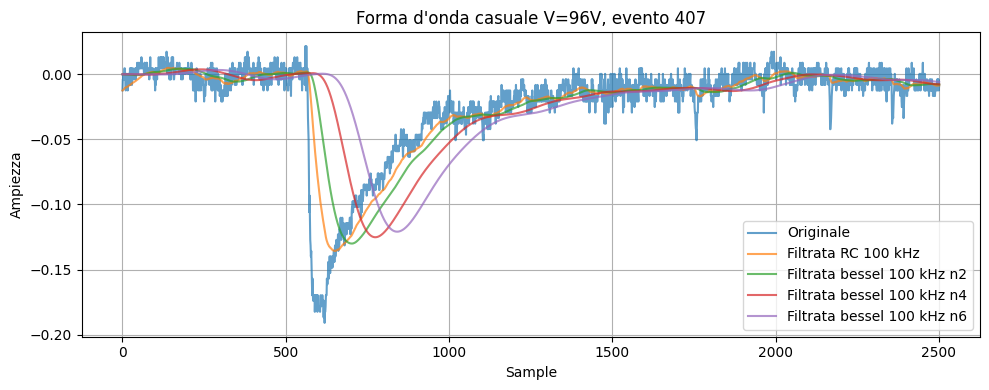

In [10]:
# scegli un voltaggio a caso tra quelli letti
V_rand = random.choice(list(pshapes_dict_188.keys()))

# scegli un evento a caso
idx_rand = random.randint(0, pshapes_dict_188[V_rand].shape[0] - 1)

wave_raw = pshapes_dict_188[V_rand][idx_rand]
wave_filt_100kHz = pshapes_dict_188_100kHz[V_rand][idx_rand]
wave_filt_100kHz_b2 = pshapes_dict_188_100kHz_b2[V_rand][idx_rand]
wave_filt_100kHz_b4 = pshapes_dict_188_100kHz_b4[V_rand][idx_rand]
wave_filt_100kHz_b6 = pshapes_dict_188_100kHz_b6[V_rand][idx_rand]

plt.figure(figsize=(10,4))
plt.plot(wave_raw, label="Originale", alpha=0.7)
plt.plot(wave_filt_100kHz, label="Filtrata RC 100 kHz ", alpha=0.7)
plt.plot(wave_filt_100kHz_b2, label="Filtrata bessel 100 kHz n2", alpha=0.7)
plt.plot(wave_filt_100kHz_b4, label="Filtrata bessel 100 kHz n4", alpha=0.7)
plt.plot(wave_filt_100kHz_b6, label="Filtrata bessel 100 kHz n6", alpha=0.7)
plt.title(f"Forma d'onda casuale V={V_rand}V, evento {idx_rand}")
plt.xlabel("Sample")
plt.ylabel("Ampiezza")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Filtraggio pshapes @ 100 kHz & 10 kHz - CD188

In [ ]:
# Funzioni di prima (rc_lowpass, plot_min_histogram, plot_random_waveform) già definite
# Assumiamo asymmetric_gaussian anche definita ma non usata qui ancora

path_root_188 = "/Users/massimo/Documents/phd/PTOLEMY/CD data/data/root/CD188/conteggi"

# dizionari per salvare array pshape
pshapes_dict_188        = {} # vettori originali
pshapes_dict_188_100kHz = {} # vettori filtrati @ 100kHz
pshapes_dict_188_10kHz  = {} # vettori filtrati @ 10kHz

for V_188 in range(95, 106):  # da 95 a 105 inclusi
    root_file_188 = f"{path_root_188}/{V_188}V/CD188_{V_188}V_treeraw.root"
    
    # Leggi file ROOT
    with uproot.open(root_file_188) as f:
        tree_188 = f["treeraw"]
        pshapes_188 = tree_188["pshape"].array(library="np")
        sampling_time_188 = tree_188["sampling_time"].array(library="np")[0]  # un valore per evento
    
    # Salva vettori originali
    pshapes_dict_188[V_188] = pshapes_188
    
    # Applica filtro RC digitale con barra grafica
    filtered_pshapes_100kHz_188 = rc_lowpass(pshapes_188, sampling_time_s=sampling_time_188, fc=100000)
    filtered_pshapes_10kHz_188  = rc_lowpass(pshapes_188, sampling_time_s=sampling_time_188, fc=10000)
    pshapes_dict_188_100kHz[V_188] = filtered_pshapes_100kHz_188
    pshapes_dict_188_10kHz[V_188]  = filtered_pshapes_10kHz_188
    
    print(f"Voltaggio {V_188}V: {pshapes_188.shape[0]} vettori salvati, filtrati con RC 100 & 10 kHz")

### Scrittura su file di pshape filtrate @ 100 kHz & 10 kHz - CD188

In [ ]:
output_base_188 = "/Users/massimo/Documents/phd/PTOLEMY/CD data/data/pshape_filtered_CD188"
os.makedirs(output_base_188, exist_ok=True)

for V in pshapes_dict_188_10kHz:
    out_path_188 = os.path.join(output_base_188, f"{V}V_filteredpshapes_10kHz_188.txt")
    with open(out_path_188, "w") as f:
        for i in tqdm(range(len(pshapes_dict_188_10kHz[V])), total=len(pshapes_dict_188_10kHz[V]), desc=f"Scrittura pshape filtrate {V}V @ 10kHz"):
            f.write(f"pshape nm {i}\n")
            for x_idx, y_val in enumerate(pshapes_dict_188_10kHz[V][i]):
                f.write(f"{x_idx} {y_val}\n")
                
for V in pshapes_dict_188_100kHz:
    out_path_188 = os.path.join(output_base_188, f"{V}V_filteredpshapes_100kHz_188.txt")
    with open(out_path_188, "w") as f:
        for i in tqdm(range(len(pshapes_dict_188_100kHz[V])), total=len(pshapes_dict_188_100kHz[V]), desc=f"Scrittura pshape filtrate {V}V @ 100kHz"):
            f.write(f"pshape nm {i}\n")
            for x_idx, y_val in enumerate(pshapes_dict_188_100kHz[V][i]):
                f.write(f"{x_idx} {y_val}\n")

### Filtraggio pshapes @ 10 kHz - CD204

In [ ]:
# Funzioni di prima (rc_lowpass, plot_min_histogram, plot_random_waveform) già definite
# Assumiamo asymmetric_gaussian anche definita ma non usata qui ancora

path_root_204 = "/Users/massimo/Documents/phd/PTOLEMY/CD data/data/root/CD204/B60_post_cond3_moku"

# dizionari per salvare array pshape
pshapes_dict_204        = {} # vettori originali
pshapes_dict_10kHz_204  = {} # vettori filtrati @ 10kHz

for V_204 in range(96, 104):  # da 96 a 103 inclusi
    root_file_204 = f"{path_root_204}/{V_204}V/CD204_{V_204}V_treeraw.root"
    
    # Leggi file ROOT
    with uproot.open(root_file_204) as f:
        tree_204 = f["treeraw"]
        pshapes_204 = tree_204["pshape"].array(library="np")
        sampling_time_204 = tree_204["sampling_time"].array(library="np")[0]  # un valore per evento
    
    # Salva vettori originali
    pshapes_dict_204[V_204] = pshapes_204
    
    # Applica filtro RC digitale con barra grafica
    filtered_pshapes_204_10kHz = rc_lowpass(pshapes_204, sampling_time_s=sampling_time_204, fc=10000)
    pshapes_dict_10kHz_204[V_204] = filtered_pshapes_204_10kHz
    
    print(f"Voltaggio {V_204}V: {pshapes_204.shape[0]} vettori salvati, filtrati con RC @ 10 kHz")

### Scrittura su file di pshape filtrate @ 10 kHz - CD204

In [ ]:
output_base_204 = "/Users/massimo/Documents/phd/PTOLEMY/CD data/data/pshape_filtered_CD204"
os.makedirs(output_base_204, exist_ok=True)

for V in pshapes_dict_10kHz_204:
    out_path_204 = os.path.join(output_base_204, f"{V}V_filteredpshapes_10kHz_204.txt")
    with open(out_path_204, "w") as f:
        for i in tqdm(range(len(pshapes_dict_10kHz_204[V])), total=len(pshapes_dict_10kHz_204[V]), desc=f"Scrittura pshape filtrate {V}V @ 10kHz"):
            f.write(f"pshape nm {i}\n")
            for x_idx, y_val in enumerate(pshapes_dict_10kHz_204[V][i]):
                f.write(f"{x_idx} {y_val}\n")

### Filtro a cascata di 10kHz su 100kHz - CD 188

In [ ]:
# Funzioni di prima (rc_lowpass, plot_min_histogram, plot_random_waveform) già definite
# Assumiamo asymmetric_gaussian anche definita ma non usata qui ancora

path_root_188 = "/Users/massimo/Documents/phd/PTOLEMY/CD data/data/root/CD188/conteggi"

# dizionari per salvare array pshape
pshapes_dict_188            = {} # vettori originali
pshapes_dict_188_10kHz_100kHz  = {} # vettori filtrati @ 10kHz on 160kHz

for V_188 in range(95, 106):  # da 95 a 105 inclusi
    root_file_188 = f"{path_root_188}/{V_188}V/CD188_{V_188}V_treeraw.root"
    
    # Leggi file ROOT
    with uproot.open(root_file_188) as f:
        tree_188 = f["treeraw"]
        pshapes_188 = tree_188["pshape"].array(library="np")
        sampling_time_188 = tree_188["sampling_time"].array(library="np")[0]  # un valore per evento
    
    # Salva vettori originali
    pshapes_dict_188[V_188] = pshapes_188
    
    # Applica filtro RC digitale con barra grafica
    filtered_pshapes_100kHz_188 = rc_lowpass(pshapes_188, sampling_time_s=sampling_time_188, fc=100000)
    filtered_pshapes_10kHz_100kHz_188 = rc_lowpass(filtered_pshapes_100kHz_188, sampling_time_s=sampling_time_188, fc=10000)
    pshapes_dict_188_10kHz_100kHz[V_188] = filtered_pshapes_10kHz_100kHz_188
    
    print(f"Voltaggio {V_188}V: {pshapes_188.shape[0]} vettori salvati, filtrati con RC 100 & 10 kHz")

In [ ]:
# scegli un voltaggio a caso tra quelli letti
V_rand = random.choice(list(pshapes_dict_188.keys()))

# scegli un evento a caso
idx_rand = random.randint(0, pshapes_dict_188[V_rand].shape[0] - 1)

wave_raw = pshapes_dict_188[V_rand][idx_rand]
wave_filt10kHz_100kHz = pshapes_dict_188_10kHz_100kHz[V_rand][idx_rand]

plt.figure(figsize=(10,4))
plt.plot(wave_raw, label="Originale", alpha=0.7)
plt.plot(wave_filt10kHz_100kHz, label="Filtrata RC 100 kHz + 10kHz ", alpha=0.7)
plt.title(f"Forma d'onda casuale V={V_rand}V, evento {idx_rand}")
plt.xlabel("Sample")
plt.ylabel("Ampiezza")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
output_base_188 = "/Users/massimo/Documents/phd/PTOLEMY/CD data/data/pshape_filtered_CD188"
os.makedirs(output_base_188, exist_ok=True)

for V in pshapes_dict_188_10kHz_100kHz:
    out_path_188 = os.path.join(output_base_188, f"{V}V_filteredpshapes_10kHz_100kHz.txt")
    with open(out_path_188, "w") as f:
        for i in tqdm(range(len(pshapes_dict_188_10kHz_100kHz[V])), total=len(pshapes_dict_188_10kHz_100kHz[V]), desc=f"Scrittura pshape filtrate {V}V @ 100kHz + 10kHz"):
            f.write(f"pshape nm {i}\n")
            for x_idx, y_val in enumerate(pshapes_dict_188_10kHz_100kHz[V][i]):
                f.write(f"{x_idx} {y_val}\n")

### Filtro a cascata di 10kHz su 160kHz

In [ ]:
# Funzioni di prima (rc_lowpass, plot_min_histogram, plot_random_waveform) già definite
# Assumiamo asymmetric_gaussian anche definita ma non usata qui ancora

path_root_188 = "/Users/massimo/Documents/phd/PTOLEMY/CD data/data/root/CD188/conteggi"

# dizionari per salvare array pshape
pshapes_dict_188            = {} # vettori originali
pshapes_dict_188_10kHz_160kHz  = {} # vettori filtrati @ 10kHz on 160kHz

for V_188 in range(95, 106):  # da 95 a 105 inclusi
    root_file_188 = f"{path_root_188}/{V_188}V/CD188_{V_188}V_treeraw.root"
    
    # Leggi file ROOT
    with uproot.open(root_file_188) as f:
        tree_188 = f["treeraw"]
        pshapes_188 = tree_188["pshape"].array(library="np")
        sampling_time_188 = tree_188["sampling_time"].array(library="np")[0]  # un valore per evento
    
    # Salva vettori originali
    pshapes_dict_188[V_188] = pshapes_188
    
    # Applica filtro RC digitale con barra grafica
    filtered_pshapes_160kHz_188 = rc_lowpass(pshapes_188, sampling_time_s=sampling_time_188, fc=160000)
    filtered_pshapes_10kHz_160kHz_188 = rc_lowpass(filtered_pshapes_160kHz_188, sampling_time_s=sampling_time_188, fc=10000)
    pshapes_dict_188_10kHz_160kHz[V_188] = filtered_pshapes_10kHz_160kHz_188
    
    print(f"Voltaggio {V_188}V: {pshapes_188.shape[0]} vettori salvati, filtrati con RC 160 & 10 kHz")

In [ ]:
# scegli un voltaggio a caso tra quelli letti
V_rand = random.choice(list(pshapes_dict_188.keys()))

# scegli un evento a caso
idx_rand = random.randint(0, pshapes_dict_188[V_rand].shape[0] - 1)

wave_raw = pshapes_dict_188[V_rand][idx_rand]
wave_filt10kHz_100kHz = pshapes_dict_188_10kHz_100kHz[V_rand][idx_rand]
wave_filt10kHz_160kHz = pshapes_dict_188_10kHz_160kHz[V_rand][idx_rand]

plt.figure(figsize=(10,4))
plt.plot(wave_raw, label="Originale", alpha=0.7)
plt.plot(wave_filt10kHz_100kHz, label="Filtrata RC 100 kHz + 10kHz ", alpha=0.7)
plt.plot(wave_filt10kHz_160kHz, label="Filtrata RC 160 kHz + 10kHz ", alpha=0.7)
plt.title(f"Forma d'onda casuale V={V_rand}V, evento {idx_rand}")
plt.xlabel("Sample")
plt.ylabel("Ampiezza")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
output_base_188 = "/Users/massimo/Documents/phd/PTOLEMY/CD data/data/pshape_filtered_CD188"
os.makedirs(output_base_188, exist_ok=True)

for V in pshapes_dict_188_10kHz_160kHz:
    out_path_188 = os.path.join(output_base_188, f"{V}V_filteredpshapes_10kHz_160kHz.txt")
    with open(out_path_188, "w") as f:
        for i in tqdm(range(len(pshapes_dict_188_10kHz_160kHz[V])), total=len(pshapes_dict_188_10kHz_160kHz[V]), desc=f"Scrittura pshape filtrate {V}V @ 160kHz + 10kHz"):
            f.write(f"pshape nm {i}\n")
            for x_idx, y_val in enumerate(pshapes_dict_188_10kHz_160kHz[V][i]):
                f.write(f"{x_idx} {y_val}\n")

### Filtro a cascata di 10kHz su 100kHz su 160kHz - CD 188

In [ ]:
# Funzioni di prima (rc_lowpass, plot_min_histogram, plot_random_waveform) già definite
# Assumiamo asymmetric_gaussian anche definita ma non usata qui ancora

path_root_188 = "/Users/massimo/Documents/phd/PTOLEMY/CD data/data/root/CD188/conteggi"

# dizionari per salvare array pshape
pshapes_dict_188            = {} # vettori originali
pshapes_dict_188_10kHz_100kHz_160kHz  = {} # vettori filtrati @ 10kHz on 160kHz

for V_188 in range(95, 106):  # da 95 a 105 inclusi
    root_file_188 = f"{path_root_188}/{V_188}V/CD188_{V_188}V_treeraw.root"
    
    # Leggi file ROOT
    with uproot.open(root_file_188) as f:
        tree_188 = f["treeraw"]
        pshapes_188 = tree_188["pshape"].array(library="np")
        sampling_time_188 = tree_188["sampling_time"].array(library="np")[0]  # un valore per evento
    
    # Salva vettori originali
    pshapes_dict_188[V_188] = pshapes_188
    
    # Applica filtro RC digitale con barra grafica
    filtered_pshapes_160kHz_188 = rc_lowpass(pshapes_188, sampling_time_s=sampling_time_188, fc=160000)
    filtered_pshapes_100kHz_160kHz_188 = rc_lowpass(filtered_pshapes_160kHz_188, sampling_time_s=sampling_time_188, fc=100000)
    filtered_pshapes_10kHz_100kHz_160kHz_188 = rc_lowpass(filtered_pshapes_100kHz_160kHz_188, sampling_time_s=sampling_time_188, fc=10000)
    pshapes_dict_188_10kHz_100kHz_160kHz[V_188] = filtered_pshapes_10kHz_100kHz_160kHz_188
    
    print(f"Voltaggio {V_188}V: {pshapes_188.shape[0]} vettori salvati, filtrati con RC 160 & 10 kHz")

In [ ]:
# scegli un voltaggio a caso tra quelli letti
V_rand = random.choice(list(pshapes_dict_188.keys()))

# scegli un evento a caso
idx_rand = random.randint(0, pshapes_dict_188[V_rand].shape[0] - 1)

wave_raw = pshapes_dict_188[V_rand][idx_rand]
wave_filt10kHz_100kHz_160kHz = pshapes_dict_188_10kHz_100kHz_160kHz[V_rand][idx_rand]

plt.figure(figsize=(10,4))
plt.plot(wave_raw, label="Originale", alpha=0.7)
plt.plot(wave_filt10kHz_100kHz_160kHz, label="Filtrata RC 160 kHz + 100kHz + 10kHz ", alpha=0.7)
plt.title(f"Forma d'onda casuale V={V_rand}V, evento {idx_rand}")
plt.xlabel("Sample")
plt.ylabel("Ampiezza")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
output_base_188 = "/Users/massimo/Documents/phd/PTOLEMY/CD data/data/pshape_filtered_CD188"
os.makedirs(output_base_188, exist_ok=True)

for V in pshapes_dict_188_10kHz_100kHz_160kHz:
    out_path_188 = os.path.join(output_base_188, f"{V}V_filteredpshapes_10kHz_100kHz_160kHz.txt")
    with open(out_path_188, "w") as f:
        for i in tqdm(range(len(pshapes_dict_188_10kHz_100kHz_160kHz[V])), total=len(pshapes_dict_188_10kHz_100kHz_160kHz[V]), desc=f"Scrittura pshape filtrate {V}V @ 160kHz + 100kHz + 10kHz"):
            f.write(f"pshape nm {i}\n")
            for x_idx, y_val in enumerate(pshapes_dict_188_10kHz_100kHz_160kHz[V][i]):
                f.write(f"{x_idx} {y_val}\n")

### Filtro a cascata di 10kHz su 160kHz - CD 204

In [ ]:
# Funzioni di prima (rc_lowpass, plot_min_histogram, plot_random_waveform) già definite
# Assumiamo asymmetric_gaussian anche definita ma non usata qui ancora

path_root_204 = "/Users/massimo/Documents/phd/PTOLEMY/CD data/data/root/CD204/B60_post_cond3_moku"

# dizionari per salvare array pshape
pshapes_dict_204            = {} # vettori originali
pshapes_dict_204_10kHz_160kHz  = {} # vettori filtrati @ 10kHz on 160kHz

for V_204 in range(96, 104):  # da 96 a 103 inclusi
    root_file_204 = f"{path_root_204}/{V_204}V/CD204_{V_204}V_treeraw.root"
    
    # Leggi file ROOT
    with uproot.open(root_file_204) as f:
        tree_204 = f["treeraw"]
        pshapes_204 = tree_204["pshape"].array(library="np")
        sampling_time_204 = tree_204["sampling_time"].array(library="np")[0]  # un valore per evento
    
    # Salva vettori originali
    pshapes_dict_204[V_204] = pshapes_204
    
    # Applica filtro RC digitale con barra grafica
    filtered_pshapes_160kHz_204 = rc_lowpass(pshapes_204, sampling_time_s=sampling_time_204, fc=160000)
    filtered_pshapes_10kHz_160kHz_204 = rc_lowpass(filtered_pshapes_160kHz_204, sampling_time_s=sampling_time_204, fc=10000)
    pshapes_dict_204_10kHz_160kHz[V_204] = filtered_pshapes_10kHz_160kHz_204
    
    print(f"Voltaggio {V_204}V: {pshapes_204.shape[0]} vettori salvati, filtrati con RC 160 & 10 kHz")

In [ ]:
output_base_204 = "/Users/massimo/Documents/phd/PTOLEMY/CD data/data/pshape_filtered_CD204"
os.makedirs(output_base_204, exist_ok=True)

for V in pshapes_dict_204_10kHz_160kHz:
    out_path_204 = os.path.join(output_base_204, f"{V}V_filteredpshapes_10kHz_160kHz.txt")
    with open(out_path_204, "w") as f:
        for i in tqdm(range(len(pshapes_dict_204_10kHz_160kHz[V])), total=len(pshapes_dict_204_10kHz_160kHz[V]), desc=f"Scrittura pshape filtrate {V}V @ 160kHz + 10kHz"):
            f.write(f"pshape nm {i}\n")
            for x_idx, y_val in enumerate(pshapes_dict_204_10kHz_160kHz[V][i]):
                f.write(f"{x_idx} {y_val}\n")

### Filtro di 100kHz - CD 222

In [ ]:
# Funzioni di prima (rc_lowpass, plot_min_histogram, plot_random_waveform) già definite
# Assumiamo asymmetric_gaussian anche definita ma non usata qui ancora

path_root_222 = "/Users/massimo/Documents/phd/PTOLEMY/CD data/data/root/CD222/E100_squidfilter_ER_031025_tr12"

# dizionari per salvare array pshape
pshapes_dict_222         = {} # vettori originali
pshapes_dict_222_100kHz  = {} # vettori filtrati @ 10kHz on 160kHz

for V_222 in range(122, 129):  # da 122 a 128 inclusi
    root_file_222 = f"{path_root_222}/{V_222}V/CD222_{V_222}V_treeraw.root"
    
    # Leggi file ROOT
    with uproot.open(root_file_222) as f:
        tree_222 = f["treeraw"]
        pshapes_222 = tree_222["pshape"].array(library="np")
        sampling_time_222 = tree_222["sampling_time"].array(library="np")[0]  # un valore per evento
    
    # Salva vettori originali
    pshapes_dict_222[V_222] = pshapes_222
    
    # Applica filtro RC digitale con barra grafica
    filtered_pshapes_100kHz_222 = rc_lowpass(pshapes_222, sampling_time_s=sampling_time_222, fc=100000)
    pshapes_dict_222_100kHz[V_222] = filtered_pshapes_100kHz_222
    
    print(f"Voltaggio {V_222}V: {pshapes_222.shape[0]} vettori salvati, filtrati con RC 160 kHz")

In [ ]:
output_base_222 = "/Users/massimo/Documents/phd/PTOLEMY/CD data/data/pshape_filtered_CD222"
os.makedirs(output_base_222, exist_ok=True)

for V in pshapes_dict_222_100kHz:
    out_path_222 = os.path.join(output_base_222, f"{V}V_filteredpshapes_100kHz.txt")
    with open(out_path_222, "w") as f:
        for i in tqdm(range(len(pshapes_dict_222_100kHz[V])), total=len(pshapes_dict_222_100kHz[V]), desc=f"Scrittura pshape filtrate {V}V @ 100kHz"):
            f.write(f"pshape nm {i}\n")
            for x_idx, y_val in enumerate(pshapes_dict_222_100kHz[V][i]):
                f.write(f"{x_idx} {y_val}\n")

### Filtro di 10kHz - CD 222

In [3]:
# Funzioni di prima (rc_lowpass, plot_min_histogram, plot_random_waveform) già definite
# Assumiamo asymmetric_gaussian anche definita ma non usata qui ancora

path_root_222 = "/Users/massimo/Documents/phd/PTOLEMY/CD data/data/root/CD222/E100_squidfilter_ER_031025_tr12"

# dizionari per salvare array pshape
pshapes_dict_222         = {} # vettori originali
pshapes_dict_222_10kHz  = {} # vettori filtrati @ 10kHz on 160kHz

for V_222 in range(122, 129):  # da 122 a 128 inclusi
    root_file_222 = f"{path_root_222}/{V_222}V/CD222_{V_222}V_treeraw.root"
    
    # Leggi file ROOT
    with uproot.open(root_file_222) as f:
        tree_222 = f["treeraw"]
        pshapes_222 = tree_222["pshape"].array(library="np")
        sampling_time_222 = tree_222["sampling_time"].array(library="np")[0]  # un valore per evento
    
    # Salva vettori originali
    pshapes_dict_222[V_222] = pshapes_222
    
    # Applica filtro RC digitale con barra grafica
    filtered_pshapes_10kHz_222 = rc_lowpass(pshapes_222, sampling_time_s=sampling_time_222, fc=10000)
    pshapes_dict_222_10kHz[V_222] = filtered_pshapes_10kHz_222
    
    print(f"Voltaggio {V_222}V: {pshapes_222.shape[0]} vettori salvati, filtrati con RC 160 kHz")

Filtraggio RC: 100%|███████████████████████| 5019/5019 [00:05<00:00, 879.74it/s]


Voltaggio 122V: 5019 vettori salvati, filtrati con RC 160 kHz


Filtraggio RC: 100%|███████████████████████| 5005/5005 [00:05<00:00, 851.76it/s]


Voltaggio 123V: 5005 vettori salvati, filtrati con RC 160 kHz


Filtraggio RC: 100%|███████████████████████| 5023/5023 [00:05<00:00, 840.90it/s]


Voltaggio 124V: 5023 vettori salvati, filtrati con RC 160 kHz


Filtraggio RC: 100%|███████████████████████| 5018/5018 [00:05<00:00, 848.45it/s]


Voltaggio 125V: 5018 vettori salvati, filtrati con RC 160 kHz


Filtraggio RC: 100%|███████████████████████| 5022/5022 [00:05<00:00, 851.84it/s]


Voltaggio 126V: 5022 vettori salvati, filtrati con RC 160 kHz


Filtraggio RC: 100%|███████████████████████| 5039/5039 [00:05<00:00, 853.78it/s]


Voltaggio 127V: 5039 vettori salvati, filtrati con RC 160 kHz


Filtraggio RC: 100%|███████████████████████| 5035/5035 [00:05<00:00, 877.76it/s]

Voltaggio 128V: 5035 vettori salvati, filtrati con RC 160 kHz


In [4]:
output_base_222 = "/Users/massimo/Documents/phd/PTOLEMY/CD data/data/pshape_filtered_CD222"
os.makedirs(output_base_222, exist_ok=True)

for V in pshapes_dict_222_10kHz:
    out_path_222 = os.path.join(output_base_222, f"{V}V_filteredpshapes_10kHz.txt")
    with open(out_path_222, "w") as f:
        for i in tqdm(range(len(pshapes_dict_222_10kHz[V])), total=len(pshapes_dict_222_10kHz[V]), desc=f"Scrittura pshape filtrate {V}V @ 10 kHz"):
            f.write(f"pshape nm {i}\n")
            for x_idx, y_val in enumerate(pshapes_dict_222_10kHz[V][i]):
                f.write(f"{x_idx} {y_val}\n")

Scrittura pshape filtrate 122V @ 10 kHz: 100%|█| 5019/5019 [00:09<00:00, 521.81i
Scrittura pshape filtrate 123V @ 10 kHz: 100%|█| 5005/5005 [00:09<00:00, 526.83i
Scrittura pshape filtrate 124V @ 10 kHz: 100%|█| 5023/5023 [00:09<00:00, 526.66i
Scrittura pshape filtrate 125V @ 10 kHz: 100%|█| 5018/5018 [00:09<00:00, 528.90i
Scrittura pshape filtrate 126V @ 10 kHz: 100%|█| 5022/5022 [00:09<00:00, 527.98i
Scrittura pshape filtrate 127V @ 10 kHz: 100%|█| 5039/5039 [00:09<00:00, 526.13i
Scrittura pshape filtrate 128V @ 10 kHz: 100%|█| 5035/5035 [00:09<00:00, 526.12i


### Filtro di 10kHz + 10 kHz - CD 222

In [3]:
# Funzioni di prima (rc_lowpass, plot_min_histogram, plot_random_waveform) già definite
# Assumiamo asymmetric_gaussian anche definita ma non usata qui ancora

path_root_222 = "/Users/massimo/Documents/phd/PTOLEMY/CD data/data/root/CD222/E100_squidfilter_ER_031025_tr12"

# dizionari per salvare array pshape
pshapes_dict_222         = {} # vettori originali
pshapes_dict_222_10kHz_10kHz  = {} # vettori filtrati @ 10kHz on 160kHz

for V_222 in range(122, 129):  # da 122 a 128 inclusi
    root_file_222 = f"{path_root_222}/{V_222}V/CD222_{V_222}V_treeraw.root"
    
    # Leggi file ROOT
    with uproot.open(root_file_222) as f:
        tree_222 = f["treeraw"]
        pshapes_222 = tree_222["pshape"].array(library="np")
        sampling_time_222 = tree_222["sampling_time"].array(library="np")[0]  # un valore per evento
    
    # Salva vettori originali
    pshapes_dict_222[V_222] = pshapes_222
    
    # Applica filtro RC digitale con barra grafica
    filtered_pshapes_10kHz_222 = rc_lowpass(pshapes_222, sampling_time_s=sampling_time_222, fc=10000)
    filtered_pshapes_10kHz_10kHz_222 = rc_lowpass(filtered_pshapes_10kHz_222, sampling_time_s=sampling_time_222, fc=10000)
    pshapes_dict_222_10kHz_10kHz[V_222] = filtered_pshapes_10kHz_10kHz_222
    
    print(f"Voltaggio {V_222}V: {pshapes_222.shape[0]} vettori salvati, filtrati con RC 160 kHz")

Filtraggio RC: 100%|███████████████████████| 5019/5019 [00:05<00:00, 876.20it/s]


Voltaggio 122V: 5019 vettori salvati, filtrati con RC 160 kHz


Filtraggio RC: 100%|███████████████████████| 5005/5005 [00:05<00:00, 853.18it/s]


Voltaggio 123V: 5005 vettori salvati, filtrati con RC 160 kHz


Filtraggio RC: 100%|███████████████████████| 5023/5023 [00:05<00:00, 852.91it/s]


Voltaggio 124V: 5023 vettori salvati, filtrati con RC 160 kHz


Filtraggio RC: 100%|███████████████████████| 5018/5018 [00:05<00:00, 856.12it/s]


Voltaggio 125V: 5018 vettori salvati, filtrati con RC 160 kHz


Filtraggio RC: 100%|███████████████████████| 5022/5022 [00:05<00:00, 844.81it/s]


Voltaggio 126V: 5022 vettori salvati, filtrati con RC 160 kHz


Filtraggio RC: 100%|███████████████████████| 5039/5039 [00:05<00:00, 857.65it/s]


Voltaggio 127V: 5039 vettori salvati, filtrati con RC 160 kHz


Filtraggio RC: 100%|███████████████████████| 5035/5035 [00:05<00:00, 883.34it/s]

Voltaggio 128V: 5035 vettori salvati, filtrati con RC 160 kHz


In [4]:
output_base_222 = "/Users/massimo/Documents/phd/PTOLEMY/CD data/data/pshape_filtered_CD222"
os.makedirs(output_base_222, exist_ok=True)

for V in pshapes_dict_222_10kHz_10kHz:
    out_path_222 = os.path.join(output_base_222, f"{V}V_filteredpshapes_10kHz_10kHz.txt")
    with open(out_path_222, "w") as f:
        for i in tqdm(range(len(pshapes_dict_222_10kHz_10kHz[V])), total=len(pshapes_dict_222_10kHz_10kHz[V]), desc=f"Scrittura pshape filtrate {V}V @ 10 + 10 kHz"):
            f.write(f"pshape nm {i}\n")
            for x_idx, y_val in enumerate(pshapes_dict_222_10kHz_10kHz[V][i]):
                f.write(f"{x_idx} {y_val}\n")

Scrittura pshape filtrate 122V @ 10 + 10 kHz: 100%|█| 5019/5019 [00:09<00:00, 52
Scrittura pshape filtrate 123V @ 10 + 10 kHz: 100%|█| 5005/5005 [00:09<00:00, 53
Scrittura pshape filtrate 124V @ 10 + 10 kHz: 100%|█| 5023/5023 [00:09<00:00, 53
Scrittura pshape filtrate 125V @ 10 + 10 kHz: 100%|█| 5018/5018 [00:09<00:00, 53
Scrittura pshape filtrate 126V @ 10 + 10 kHz: 100%|█| 5022/5022 [00:09<00:00, 52
Scrittura pshape filtrate 127V @ 10 + 10 kHz: 100%|█| 5039/5039 [00:09<00:00, 52
Scrittura pshape filtrate 128V @ 10 + 10 kHz: 100%|█| 5035/5035 [00:09<00:00, 52


In [ ]:
# scegli un voltaggio a caso tra quelli letti
V_rand = random.choice(list(pshapes_dict_222.keys()))

# scegli un evento a caso
idx_rand = random.randint(0, pshapes_dict_222[V_rand].shape[0] - 1)
 
wave_raw = pshapes_dict_222[V_rand][idx_rand]
wave_filt10kHz = pshapes_dict_222_10kHz[V_rand][idx_rand]
wave_filt10kHz_10kHz = pshapes_dict_222_10kHz_10kHz[V_rand][idx_rand]


plt.figure(figsize=(10,4))
plt.plot(wave_raw, label="Unfiltered ", alpha=0.7)
plt.plot(wave_filt10kHz, label="Filtrata RC 10kHz ", alpha=0.7)
plt.plot(wave_filt10kHz_10kHz, label="Filtrata RC 10kHz + 10kHz ", alpha=0.7)
plt.title(f"Forma d'onda casuale V={V_rand}V, evento {idx_rand}")
plt.xlabel("Sample")
plt.ylabel("Ampiezza")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Filtro a cascata di 10kHz su 160kHz su 100kHz - CD 188

In [ ]:
# Funzioni di prima (rc_lowpass, plot_min_histogram, plot_random_waveform) già definite
# Assumiamo asymmetric_gaussian anche definita ma non usata qui ancora

path_root_188 = "/Users/massimo/Documents/phd/PTOLEMY/CD data/data/root/CD188/conteggi"

# dizionari per salvare array pshape
pshapes_dict_188            = {} # vettori originali
pshapes_dict_188_10kHz_160kHz_100kHz  = {} # vettori filtrati @ 10kHz on 160kHz

for V_188 in range(95, 106):  # da 95 a 105 inclusi
    root_file_188 = f"{path_root_188}/{V_188}V/CD188_{V_188}V_treeraw.root"
    
    # Leggi file ROOT
    with uproot.open(root_file_188) as f:
        tree_188 = f["treeraw"]
        pshapes_188 = tree_188["pshape"].array(library="np")
        sampling_time_188 = tree_188["sampling_time"].array(library="np")[0]  # un valore per evento
    
    # Salva vettori originali
    pshapes_dict_188[V_188] = pshapes_188
    
    # Applica filtro RC digitale con barra grafica
    filtered_pshapes_100kHz_188 = rc_lowpass(pshapes_188, sampling_time_s=sampling_time_188, fc=100000)
    filtered_pshapes_160kHz_100kHz_188 = rc_lowpass(filtered_pshapes_100kHz_188, sampling_time_s=sampling_time_188, fc=160000)
    filtered_pshapes_10kHz_160kHz_100kHz_188 = rc_lowpass(filtered_pshapes_160kHz_100kHz_188, sampling_time_s=sampling_time_188, fc=10000)
    pshapes_dict_188_10kHz_160kHz_100kHz[V_188] = filtered_pshapes_10kHz_160kHz_100kHz_188
    
    print(f"Voltaggio {V_188}V: {pshapes_188.shape[0]} vettori salvati, filtrati con RC 160 & 10 kHz")

In [ ]:
output_base_188 = "/Users/massimo/Documents/phd/PTOLEMY/CD data/data/pshape_filtered_CD188"
os.makedirs(output_base_188, exist_ok=True)

for V in pshapes_dict_188_10kHz_160kHz_100kHz:
    out_path_188 = os.path.join(output_base_188, f"{V}V_filteredpshapes_10kHz_160kHz_100kHz.txt")
    with open(out_path_188, "w") as f:
        for i in tqdm(range(len(pshapes_dict_188_10kHz_160kHz_100kHz[V])), total=len(pshapes_dict_188_10kHz_160kHz_100kHz[V]), desc=f"Scrittura pshape filtrate {V}V @ 10 + 160 + 100 kHz"):
            f.write(f"pshape nm {i}\n")
            for x_idx, y_val in enumerate(pshapes_dict_188_10kHz_160kHz_100kHz[V][i]):
                f.write(f"{x_idx} {y_val}\n")

In [ ]:
# scegli un voltaggio a caso tra quelli letti
V_rand = random.choice(list(pshapes_dict_188.keys()))

# scegli un evento a caso
idx_rand = random.randint(0, pshapes_dict_188[V_rand].shape[0] - 1)
 
wave_raw = pshapes_dict_188[V_rand][idx_rand]
wave_filt10kHz_100kHz_160kHz = pshapes_dict_188_10kHz_100kHz_160kHz[V_rand][idx_rand]
wave_filt10kHz_160kHz_100kHz = pshapes_dict_188_10kHz_160kHz_100kHz[V_rand][idx_rand]


plt.figure(figsize=(10,4))
#plt.plot(wave_raw, label="Originale", alpha=0.7)
#plt.plot(wave_filt10kHz_100kHz_160kHz, label="Filtrata RC 160 kHz + 100kHz + 10kHz ", alpha=0.7)
#plt.plot(wave_filt10kHz_160kHz_100kHz, label="Filtrata RC 100 kHz + 160kHz + 10kHz ", alpha=0.7, linewidth = 10)
plt.plot(wave_filt10kHz_160kHz_100kHz - wave_filt10kHz_100kHz_160kHz, label="Filtrata RC 100 kHz + 160kHz + 10kHz ", alpha=0.7)
plt.title(f"Forma d'onda casuale V={V_rand}V, evento {idx_rand}")
plt.xlabel("Sample")
plt.ylabel("Ampiezza")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()